In [1]:
%matplotlib inline
import os
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from astroML.plotting import setup_text_plots
import pdb
setup_text_plots(fontsize=25, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 25.0

In [2]:
import coronagraph as cg

In [3]:
jc = cg.filters.johnson_cousins()

In [372]:
len(jc.__dict__)

5

In [388]:
def scalarmap(v,cmap='plasma'):
    import matplotlib.cm as cmx
    import matplotlib.colors as colors
    cm = plt.get_cmap(cmap)
    cNorm  = colors.Normalize(vmin=np.min(v), vmax=np.max(v))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    colors = scalarMap.to_rgba(v)
    return colors,scalarMap,cNorm

def plot_filters(wheel, ax):

    Nfilt = len(wheel.__dict__)
    
    colors,scalarMap,cNorm = scalarmap(np.arange(Nfilt),cmap='Dark2')

    ax1 = ax.twinx()

    i = 0
    for attr, value in wheel.__dict__.iteritems():
        wl, response = value.wl, value.response
        #ax1.plot(wl,response, lw=3.0, label=value.name, c=colors[i])
        ax1.fill_between(wl,response, color=colors[i], alpha=0.3)
        i += 1

In [399]:
def convolve_filter_response(wlh, fh, wlf, response, degrade=False):
    
    # if wl grid is backwards reverse it
    if wlh[1] > wlh[0]:
        pass
    else:
        wlh=wlh[::-1]
        fh=fh[::-1]
    
    Nfilt = len(wlf)
    wlmin = np.min(wlf)
    wlmax = np.max(wlf)
    dlo = wlf[1] - wlf[0]
    dhi = wlf[-1] - wlf[-2]
    # Select only this wavelength region
    wlhr = wlh[(wlh > (wlmin-dlo*10)) & (wlh < (wlmax+dhi*10))]
    fhr = fh[(wlh > (wlmin-dlo*10)) & (wlh < (wlmax+dhi*10))]
    Nspec = len(wlhr)

    if degrade:
        try:
            F = cg.degrade_spec(fhr, wlhr, wlf)
            R = response
        except ValueError:
            print 'Error in degrade_spec, switching to numpy interpolation.'
            if Nspec > Nfilt:
                # Interpolate filter response to hi-res spectral grid
                R = np.interp(wlhr, wlf, response)
                F = fhr
            else:
                # Interpolate spectrum to hi-res filter grid
                F = np.interp(wlf, wlhr, fhr)
                R = response
    elif Nspec > Nfilt:
        # Interpolate filter response to hi-res spectral grid
        R = np.interp(wlhr, wlf, response)
        F = fhr
    else:
        # Interpolate spectrum to hi-res filter grid
        F = np.interp(wlf, wlhr, fhr)
        R = response
        
    # Convolve with normalized filter response function
    F = F * (R / np.sum(R))
    
    # Integrate by summing 
    Fc = np.sum(F)
    
    if Fc < 0.0:
        print Fc, wlf, degrade
    
    return Fc

In [6]:
def convolve_filter_FWHM(wlhr, fhr, wlc, FWHM):
    pass

In [7]:
wl, wno, solar_spec, TOA_flux, rad_streams = cg.readsmart.rad('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad')

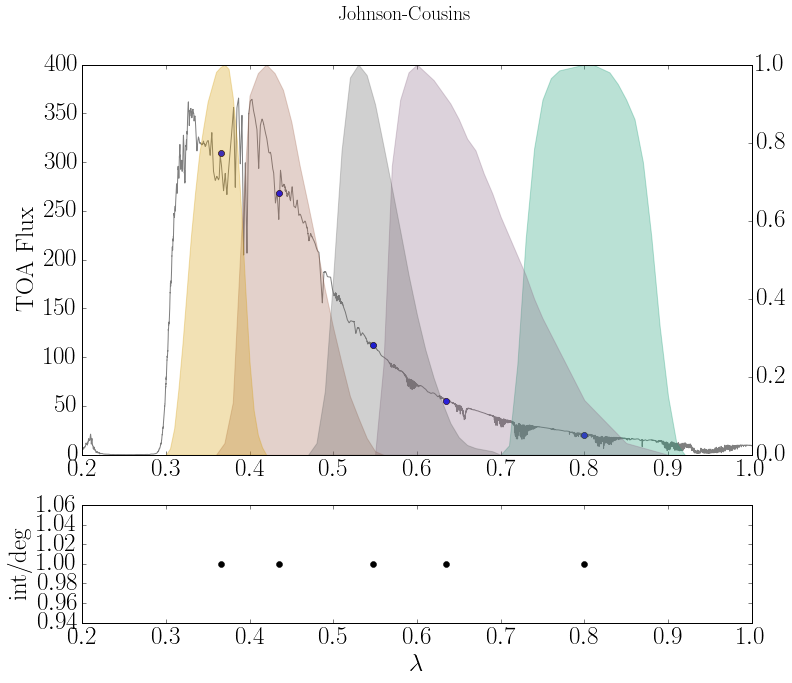

In [395]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.3]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(wl, TOA_flux, alpha=0.5, c='k')
for attr, value in jc.__dict__.iteritems():
    f1 = convolve_filter_response(wl, TOA_flux, value.wl, value.response)
    wlc1 = value.bandcenter
    ax0.plot(wlc1, f1, 'o', c='r', label=str(value.name)+' interp')
    f2 = convolve_filter_response(wl, TOA_flux, value.wl, value.response, degrade=True)
    wlc2 = value.bandcenter
    ax0.plot(wlc2, f2, 'o', c='b', label=str(value.name)+' degrade')
    ax1.plot(wlc1, f1/f2, 'o', c='k')
plot_filters(jc, ax0)
ax0.set_xlim([0.2,1.0])
ax1.set_xlim([0.2,1.0])
ax0.set_ylabel('TOA Flux')
ax1.set_ylabel('int/deg')
ax1.set_xlabel(r'$\lambda$')
fig.suptitle('Johnson-Cousins')

In [86]:
ls = cg.filters.landsat()

In [87]:
mod_ls = cg.filters.Wheel()

In [90]:
mod_ls.add_new_filter(ls.B, name='B')
mod_ls.add_new_filter(ls.CA, name='CA')
mod_ls.add_new_filter(ls.Cirrus, name='Cirrus')
mod_ls.add_new_filter(ls.G, name='G')
mod_ls.add_new_filter(ls.NIR, name='NIR')
mod_ls.add_new_filter(ls.Pan, name='Pan')
mod_ls.add_new_filter(ls.R, name='R')
mod_ls.add_new_filter(ls.SWIR1, name='SWIR1')

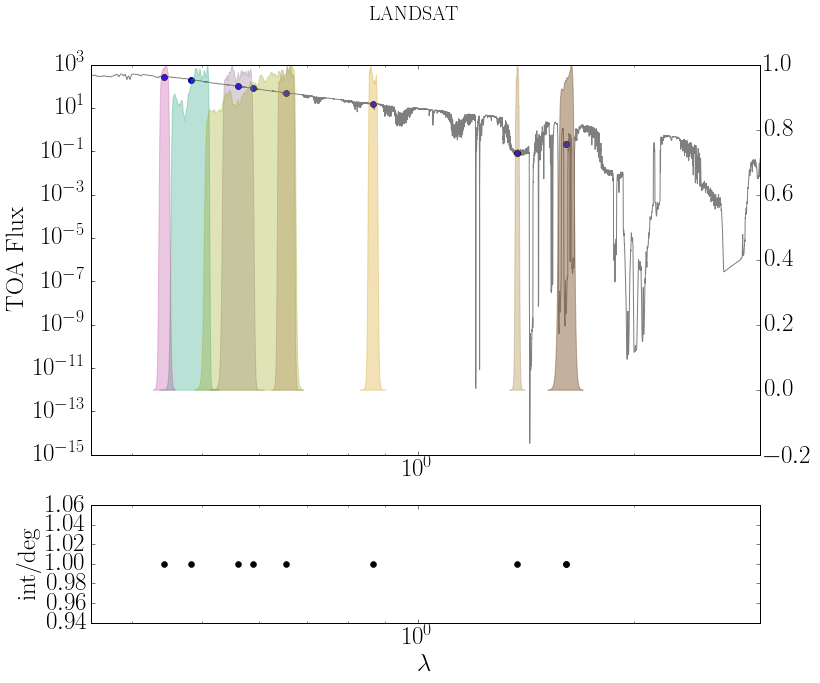

In [396]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2,1, height_ratios=[1, 0.3]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(wl, TOA_flux, alpha=0.5, c='k')
for attr, value in mod_ls.__dict__.iteritems():
    f1 = convolve_filter_response(wl, TOA_flux, value.wl, value.response)
    wlc1 = value.bandcenter
    ax0.plot(wlc1, f1, 'o', c='r', label=str(value.name)+' interp')
    f2 = convolve_filter_response(wl, TOA_flux, value.wl, value.response, degrade=True)
    wlc2 = value.bandcenter
    ax0.plot(wlc2, f2, 'o', c='b', label=str(value.name)+' degrade')
    ax1.plot(wlc1, f1/f2, 'o', c='k')
plot_filters(mod_ls, ax0)
ax0.set_xlim([0.35,3.0])
ax1.set_xlim([0.35,3.0])
#ax0.set_ylim([1e-3, 1e3])
ax0.loglog()
#ax0.semilogx()
ax1.semilogx()
ax0.set_ylabel('TOA Flux')
ax1.set_ylabel('int/deg')
ax1.set_xlabel(r'$\lambda$')
fig.suptitle('LANDSAT')

In [93]:
from scipy import interp
from scipy import ndimage

In [94]:
def tophat_instrument(Fp, wl_hr, wlgrid, FWHM=0.035):

    Fratio11=tophatfold(wl_hr, Fp, FWHM)
    Fratio=interp(wlgrid,wl_hr,Fratio11)

    return Fratio
    
def tophatfold(lam, flux, FWHM=0.035):
    lammin=min(lam)
    lammax=max(lam)
    dlambda=FWHM/17.
    interlam=np.arange(lammin,lammax,dlambda)
    interflux=interp(interlam,lam,flux)

    #convovle flux array with gaussian--use smooth
    fold=sp.ndimage.filters.uniform_filter(interflux,size=17)

    #interpolate back to original grid
    fluxfold=interp(lam,interlam,fold)

    return fluxfold

In [95]:
F = tophat_instrument(TOA_flux[::-1], wl[::-1], ls.B.bandcenter, FWHM=ls.B.FWHM)

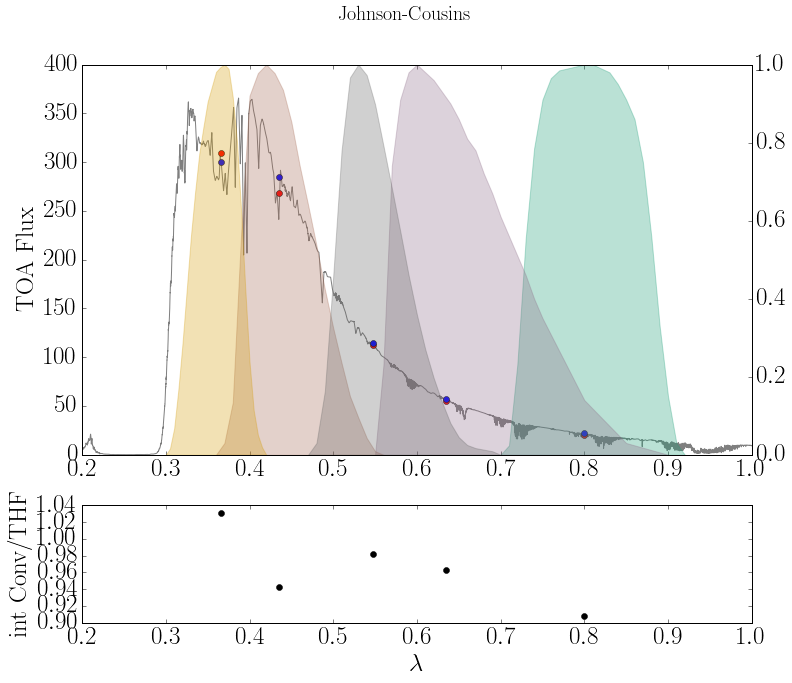

In [397]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.3]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(wl, TOA_flux, alpha=0.5, c='k')
for attr, value in jc.__dict__.iteritems():
    f1 = convolve_filter_response(wl, TOA_flux, value.wl, value.response, degrade=True)
    wlc1 = value.bandcenter
    ax0.plot(wlc1, f1, 'o', c='r', label=str(value.name)+' interp')
    f2 = tophat_instrument(TOA_flux[::-1], wl[::-1], value.bandcenter, FWHM=value.FWHM)
    wlc2 = value.bandcenter
    ax0.plot(wlc2, f2, 'o', c='b', label=str(value.name)+' degrade')
    ax1.plot(wlc1, f1/f2, 'o', c='k')
plot_filters(jc, ax0)
ax0.set_xlim([0.2,1.0])
ax1.set_xlim([0.2,1.0])
ax0.set_ylabel('TOA Flux')
ax1.set_ylabel('int Conv/THF')
ax1.set_xlabel(r'$\lambda$')
fig.suptitle('Johnson-Cousins')

Error in degrade_spec, switching to numpy interpolation.


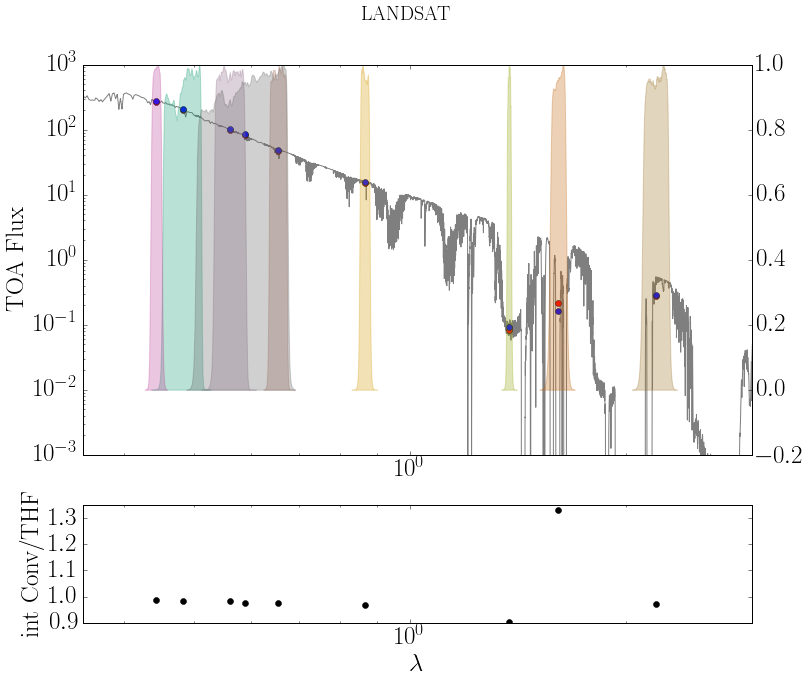

In [402]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.3]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(wl, TOA_flux, alpha=0.5, c='k')
for attr, value in ls.__dict__.iteritems():
    f1 = convolve_filter_response(wl, TOA_flux, value.wl, value.response, degrade=True)
    wlc1 = value.bandcenter
    ax0.plot(wlc1, f1, 'o', c='r', label=str(value.name)+' interp')
    f2 = tophat_instrument(TOA_flux[::-1], wl[::-1], value.bandcenter, FWHM=value.FWHM)
    wlc2 = value.bandcenter
    ax0.plot(wlc2, f2, 'o', c='b', label=str(value.name)+' degrade')
    ax1.plot(wlc1, f1/f2, 'o', c='k')

plot_filters(ls, ax0)
ax0.set_xlim([0.35,3.0])
ax1.set_xlim([0.35,3.0])
ax0.set_ylim([1e-3, 1e3])
ax0.loglog()
ax1.semilogx()
ax0.set_ylabel('TOA Flux')
ax1.set_ylabel('int Conv/THF')
ax1.set_xlabel(r'$\lambda$')
fig.suptitle('LANDSAT')

In [228]:
Nfilt = len(ls.Cirrus.wl)
wlmin = np.min(ls.Cirrus.wl)
wlmax = np.max(ls.Cirrus.wl)
print wlmin, wlmax
print Nfilt

1.34 1.409
70


In [229]:
Nspec = len(wl[(wl > wlmin) & (wl < wlmax)])
print Nspec

365


In [172]:
len(ls.SWIR2.wl)

319

loop 1


(0, 1)

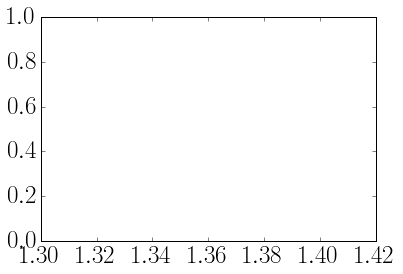

In [323]:
f1 = convolve_filter_response(wl, TOA_flux, ls.Cirrus.wl, ls.Cirrus.response, degrade=False)
plt.xlim([1.3, 1.42])
plt.ylim([0,1])